In [13]:
import os
import os.path as op
import numpy as np
import nibabel as nib
import pandas as pd
from nilearn.maskers import NiftiMasker
from nilearn import datasets
from nilearn.image import threshold_img

## Define Dice Coefficient Function
The Dice coefficient measures the overlap between two binary masks, ranging from 0 (no overlap) to 1 (perfect overlap).

In [14]:
def dice_coefficient(mask1, mask2, brain_mask=None):
    """
    Calculate Dice similarity coefficient between two binary masks.
    
    Dice = 2 * |X ∩ Y| / (|X| + |Y|)
    
    Parameters:
    -----------
    mask1, mask2 : array-like
        Binary masks (1D or 3D arrays)
    brain_mask : array-like, optional
        Binary mask to restrict analysis to brain voxels
    
    Returns:
    --------
    dice : float
        Dice coefficient (0-1)
    """
    # Flatten arrays if needed
    mask1_flat = mask1.flatten()
    mask2_flat = mask2.flatten()
    
    # Apply brain mask if provided
    if brain_mask is not None:
        brain_mask_flat = brain_mask.flatten().astype(bool)
        mask1_flat = mask1_flat[brain_mask_flat]
        mask2_flat = mask2_flat[brain_mask_flat]
    
    # Calculate intersection and sizes
    intersection = np.sum(mask1_flat * mask2_flat)
    size1 = np.sum(mask1_flat)
    size2 = np.sum(mask2_flat)
    
    # Avoid division by zero
    if size1 + size2 == 0:
        return 0.0
    
    dice = (2.0 * intersection) / (size1 + size2)
    return dice

In [15]:
def weighted_dice_coefficient(map1, map2, brain_mask=None):
    """
    Calculate weighted Dice similarity coefficient between two continuous-valued maps.
    Weights voxels by their activation strength (absolute value).
    
    Weighted Dice = 2 * Σ(min(|X|, |Y|)) / (Σ|X| + Σ|Y|)
    
    Parameters:
    -----------
    map1, map2 : array-like
        Continuous-valued activation maps (1D or 3D arrays)
    brain_mask : array-like, optional
        Binary mask to restrict analysis to brain voxels
    
    Returns:
    --------
    weighted_dice : float
        Weighted Dice coefficient (0-1)
    """
    # Flatten arrays if needed
    map1_flat = map1.flatten()
    map2_flat = map2.flatten()
    
    # Apply brain mask if provided
    if brain_mask is not None:
        brain_mask_flat = brain_mask.flatten().astype(bool)
        map1_flat = map1_flat[brain_mask_flat]
        map2_flat = map2_flat[brain_mask_flat]
    
    # Use absolute values to handle negative activations
    map1_abs = np.abs(map1_flat)
    map2_abs = np.abs(map2_flat)
    
    # Calculate weighted intersection (minimum activation at each voxel)
    weighted_intersection = np.sum(np.minimum(map1_abs, map2_abs))
    
    # Calculate sum of activations
    sum1 = np.sum(map1_abs)
    sum2 = np.sum(map2_abs)
    
    # Avoid division by zero
    if sum1 + sum2 == 0:
        return 0.0
    
    weighted_dice = (2.0 * weighted_intersection) / (sum1 + sum2)
    return weighted_dice

In [16]:
def permutation_test_dice(map1, map2, dice_func, n_permutations=10000, seed=42, restrict_to_active=True):
    """
    Perform permutation test to assess statistical significance of Dice coefficient.
    Tests whether observed overlap is greater than expected by chance by randomly
    shuffling the spatial correspondence between the two maps.
    
    Parameters:
    -----------
    map1, map2 : array-like
        Maps to compare (binary or continuous, from masker.transform())
    dice_func : function
        Function to calculate Dice (dice_coefficient or weighted_dice_coefficient)
    n_permutations : int
        Number of permutations to perform
    seed : int
        Random seed for reproducibility
    restrict_to_active : bool
        If True, only permute non-zero voxels (tests overlap among activated regions)
        If False, permute all brain voxels (tests spatial pattern similarity including zeros)
    
    Returns:
    --------
    p_value : float
        One-tailed p-value (proportion of permutations with Dice >= observed)
    null_distribution : array
        Dice coefficients from permuted data
    observed_dice : float
        Observed Dice coefficient
    """
    rng = np.random.RandomState(seed)
    
    # Ensure arrays are 1D
    if map1.ndim > 1:
        map1 = map1.flatten()
    if map2.ndim > 1:
        map2 = map2.flatten()
    
    if restrict_to_active:
        # Create mask for voxels that are non-zero in at least one map
        active_voxels = (map1 != 0) | (map2 != 0)
        
        # Restrict analysis to active voxels only
        map1_test = map1[active_voxels]
        map2_test = map2[active_voxels]
        
        print(f"  Restricting permutation to {np.sum(active_voxels)} active voxels (out of {len(map1)} total)")
    else:
        # Use all voxels
        map1_test = map1
        map2_test = map2
        print(f"  Permuting all {len(map1)} brain voxels")
    
    # Calculate observed Dice
    observed_dice = dice_func(map1_test, map2_test)
    
    # Initialize null distribution
    null_dice = np.zeros(n_permutations)
    
    # Perform permutations
    for i in range(n_permutations):
        # Randomly shuffle map2 to break spatial correspondence
        map2_permuted = rng.permutation(map2_test)
        # Calculate Dice for permuted data
        null_dice[i] = dice_func(map1_test, map2_permuted)
    
    # Calculate one-tailed p-value
    # p-value = proportion of null distribution >= observed
    # Small p-value means observed is significantly greater than chance
    p_value = np.sum(null_dice >= observed_dice) / n_permutations
    
    return p_value, null_dice, observed_dice

## Setup Directories and Masker

In [17]:
data_dir = "./dset"

# Setup masker
mask_img = datasets.load_mni152_brain_mask(resolution=1)
masker = NiftiMasker(mask_img=mask_img)
masker = masker.fit()

# Load MNI152 template to use as brain mask
template_img = datasets.load_mni152_template(resolution=1)
template_data = template_img.get_fdata()
brain_mask = (template_data != 0).astype(int)

print(f"Brain mask shape: {brain_mask.shape}")
print(f"Brain voxels: {np.sum(brain_mask)}")

Brain mask shape: (197, 233, 189)
Brain voxels: 1886539


## Define File Paths

In [18]:
# Group directories
group_drawn_dir = op.join(data_dir, "group-drawn/habenula")
group_avg_dir = op.join(data_dir, "group-avg/habenula")

# File paths for group average (1-sample) maps
drawn_1s_fn = op.join(group_drawn_dir, "averaged", "sub-group_task-rest_desc-1SampletTest_thresh.nii.gz")
avg_1s_fn = op.join(group_avg_dir, "averaged", "sub-group_task-rest_desc-1SampletTest_thresh.nii.gz")

# File paths for group comparison (2-sample) maps
drawn_2s_fn = op.join(group_drawn_dir, "difference", "sub-group_task-rest_desc-2SampletTest_thresh.nii.gz")
avg_2s_fn = op.join(group_avg_dir, "difference", "sub-group_task-rest_desc-2SampletTest_thresh.nii.gz")

print("File paths defined:")
print(f"Drawn 1-sample: {drawn_1s_fn}")
print(f"Avg 1-sample: {avg_1s_fn}")
print(f"Drawn 2-sample: {drawn_2s_fn}")
print(f"Avg 2-sample: {avg_2s_fn}")

File paths defined:
Drawn 1-sample: ./dset/group-drawn/habenula/averaged/sub-group_task-rest_desc-1SampletTest_thresh.nii.gz
Avg 1-sample: ./dset/group-avg/habenula/averaged/sub-group_task-rest_desc-1SampletTest_thresh.nii.gz
Drawn 2-sample: ./dset/group-drawn/habenula/difference/sub-group_task-rest_desc-2SampletTest_thresh.nii.gz
Avg 2-sample: ./dset/group-avg/habenula/difference/sub-group_task-rest_desc-2SampletTest_thresh.nii.gz


## Calculate Dice Coefficients for Group Average Maps (1-Sample)

In [19]:
# Check if files exist
if not op.exists(drawn_1s_fn):
    print(f"ERROR: File not found: {drawn_1s_fn}")
elif not op.exists(avg_1s_fn):
    print(f"ERROR: File not found: {avg_1s_fn}")
else:
    # Load thresholded maps
    drawn_1s_img = nib.load(drawn_1s_fn)
    avg_1s_img = nib.load(avg_1s_fn)
    
    # Convert to arrays (masker already applies brain mask)
    drawn_1s_arr = masker.transform(drawn_1s_img)
    avg_1s_arr = masker.transform(avg_1s_img)
    
    # Create binary masks (any non-zero value = 1)
    drawn_1s_binary = (drawn_1s_arr != 0).astype(int)
    avg_1s_binary = (avg_1s_arr != 0).astype(int)
    
    # Calculate binary Dice coefficient (masker already restricts to brain voxels)
    dice_1s = dice_coefficient(drawn_1s_binary, avg_1s_binary)
    
    # Calculate weighted Dice coefficient (uses activation strength)
    weighted_dice_1s = weighted_dice_coefficient(drawn_1s_arr, avg_1s_arr)
    
    # Perform permutation tests
    print("\n=== Group Average (1-Sample) ===")
    
    # Check if binary maps are identical
    if np.array_equal(drawn_1s_binary.flatten(), avg_1s_binary.flatten()):
        print("Binary maps are identical - permutation test not applicable")
        p_binary_1s_active = np.nan
        null_binary_1s_active = np.array([dice_1s])
        obs_binary_1s_active = dice_1s
        p_binary_1s_all = np.nan
        null_binary_1s_all = np.array([dice_1s])
        obs_binary_1s_all = dice_1s
    else:
        print("\n[Active Voxels Only]")
        print("Running binary permutation test (10,000 permutations)...")
        p_binary_1s_active, null_binary_1s_active, obs_binary_1s_active = permutation_test_dice(
            drawn_1s_binary, avg_1s_binary, dice_coefficient, n_permutations=10000, restrict_to_active=True
        )
        
        print("\n[All Brain Voxels]")
        print("Running binary permutation test (10,000 permutations)...")
        p_binary_1s_all, null_binary_1s_all, obs_binary_1s_all = permutation_test_dice(
            drawn_1s_binary, avg_1s_binary, dice_coefficient, n_permutations=10000, restrict_to_active=False
        )
    
    print("\n[Active Voxels Only]")
    print("Running weighted permutation test (10,000 permutations)...")
    p_weighted_1s_active, null_weighted_1s_active, obs_weighted_1s_active = permutation_test_dice(
        drawn_1s_arr, avg_1s_arr, weighted_dice_coefficient, n_permutations=10000, restrict_to_active=True
    )
    
    print("\n[All Brain Voxels]")
    print("Running weighted permutation test (10,000 permutations)...")
    p_weighted_1s_all, null_weighted_1s_all, obs_weighted_1s_all = permutation_test_dice(
        drawn_1s_arr, avg_1s_arr, weighted_dice_coefficient, n_permutations=10000, restrict_to_active=False
    )
    
    # Print results
    print("\n=== Results ===")
    if np.isnan(p_binary_1s_active):
        print(f"Binary Dice Coefficient: {dice_1s:.4f} (identical maps)")
    else:
        print(f"Binary Dice (Active Voxels): {dice_1s:.4f} (p = {p_binary_1s_active if p_binary_1s_active > 0 else '< 0.0001'})")
        print(f"Binary Dice (All Voxels): {dice_1s:.4f} (p = {p_binary_1s_all if p_binary_1s_all > 0 else '< 0.0001'})")
    
    print(f"Weighted Dice (Active Voxels): {weighted_dice_1s:.4f} (p = {p_weighted_1s_active if p_weighted_1s_active > 0 else '< 0.0001'})")
    print(f"Weighted Dice (All Voxels): {weighted_dice_1s:.4f} (p = {p_weighted_1s_all if p_weighted_1s_all > 0 else '< 0.0001'})")
    
    print(f"\nHand-drawn map voxels: {np.sum(drawn_1s_binary)}")
    print(f"Average habenula map voxels: {np.sum(avg_1s_binary)}")
    print(f"Overlapping voxels: {np.sum(drawn_1s_binary * avg_1s_binary)}")

/Users/chloehampson/Desktop/habenula-abide-rsfc/.venv/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/Users/chloehampson/Desktop/habenula-abide-rsfc/.venv/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/Users/chloehampson/Desktop/habenula-abide-rsfc/.venv/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You mig


=== Group Average (1-Sample) ===
Binary maps are identical - permutation test not applicable

[Active Voxels Only]
Running weighted permutation test (10,000 permutations)...
  Restricting permutation to 1882989 active voxels (out of 1882989 total)

[All Brain Voxels]
Running weighted permutation test (10,000 permutations)...
  Permuting all 1882989 brain voxels

[All Brain Voxels]
Running weighted permutation test (10,000 permutations)...
  Permuting all 1882989 brain voxels

=== Results ===
Binary Dice Coefficient: 1.0000 (identical maps)
Weighted Dice (Active Voxels): 0.7498 (p = < 0.0001)
Weighted Dice (All Voxels): 0.7498 (p = < 0.0001)

Hand-drawn map voxels: 1882989
Average habenula map voxels: 1882989
Overlapping voxels: 1882989

=== Results ===
Binary Dice Coefficient: 1.0000 (identical maps)
Weighted Dice (Active Voxels): 0.7498 (p = < 0.0001)
Weighted Dice (All Voxels): 0.7498 (p = < 0.0001)

Hand-drawn map voxels: 1882989
Average habenula map voxels: 1882989
Overlapping vox

In [20]:
# Check if files exist
if not op.exists(drawn_2s_fn):
    print(f"ERROR: File not found: {drawn_2s_fn}")
elif not op.exists(avg_2s_fn):
    print(f"ERROR: File not found: {avg_2s_fn}")
else:
    # Load thresholded maps
    drawn_2s_img = nib.load(drawn_2s_fn)
    avg_2s_img = nib.load(avg_2s_fn)
    
    # Convert to arrays (masker already applies brain mask)
    drawn_2s_arr = masker.transform(drawn_2s_img)
    avg_2s_arr = masker.transform(avg_2s_img)
    
    # Create binary masks (any non-zero value = 1)
    drawn_2s_binary = (drawn_2s_arr != 0).astype(int)
    avg_2s_binary = (avg_2s_arr != 0).astype(int)
    
    # Calculate binary Dice coefficient (masker already restricts to brain voxels)
    dice_2s = dice_coefficient(drawn_2s_binary, avg_2s_binary)
    
    # Calculate weighted Dice coefficient (uses activation strength)
    weighted_dice_2s = weighted_dice_coefficient(drawn_2s_arr, avg_2s_arr)
    
    # Perform permutation tests
    print("\n=== Group Comparison (2-Sample) ===")
    
    print("\n[Active Voxels Only]")
    print("Running binary permutation test (10,000 permutations)...")
    p_binary_2s_active, null_binary_2s_active, obs_binary_2s_active = permutation_test_dice(
        drawn_2s_binary, avg_2s_binary, dice_coefficient, n_permutations=10000, restrict_to_active=True
    )
    
    print("\n[All Brain Voxels]")
    print("Running binary permutation test (10,000 permutations)...")
    p_binary_2s_all, null_binary_2s_all, obs_binary_2s_all = permutation_test_dice(
        drawn_2s_binary, avg_2s_binary, dice_coefficient, n_permutations=10000, restrict_to_active=False
    )
    
    print("\n[Active Voxels Only]")
    print("Running weighted permutation test (10,000 permutations)...")
    p_weighted_2s_active, null_weighted_2s_active, obs_weighted_2s_active = permutation_test_dice(
        drawn_2s_arr, avg_2s_arr, weighted_dice_coefficient, n_permutations=10000, restrict_to_active=True
    )
    
    print("\n[All Brain Voxels]")
    print("Running weighted permutation test (10,000 permutations)...")
    p_weighted_2s_all, null_weighted_2s_all, obs_weighted_2s_all = permutation_test_dice(
        drawn_2s_arr, avg_2s_arr, weighted_dice_coefficient, n_permutations=10000, restrict_to_active=False
    )
    
    # Print results
    print("\n=== Results ===")
    print(f"Binary Dice (Active Voxels): {dice_2s:.4f} (p = {p_binary_2s_active if p_binary_2s_active > 0 else '< 0.0001'})")
    print(f"Binary Dice (All Voxels): {dice_2s:.4f} (p = {p_binary_2s_all if p_binary_2s_all > 0 else '< 0.0001'})")
    print(f"Weighted Dice (Active Voxels): {weighted_dice_2s:.4f} (p = {p_weighted_2s_active if p_weighted_2s_active > 0 else '< 0.0001'})")
    print(f"Weighted Dice (All Voxels): {weighted_dice_2s:.4f} (p = {p_weighted_2s_all if p_weighted_2s_all > 0 else '< 0.0001'})")
    
    print(f"\nHand-drawn map voxels: {np.sum(drawn_2s_binary)}")
    print(f"Average habenula map voxels: {np.sum(avg_2s_binary)}")
    print(f"Overlapping voxels: {np.sum(drawn_2s_binary * avg_2s_binary)}")

/Users/chloehampson/Desktop/habenula-abide-rsfc/.venv/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/Users/chloehampson/Desktop/habenula-abide-rsfc/.venv/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/Users/chloehampson/Desktop/habenula-abide-rsfc/.venv/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You mig


=== Group Comparison (2-Sample) ===

[Active Voxels Only]
Running binary permutation test (10,000 permutations)...
  Restricting permutation to 1389510 active voxels (out of 1882989 total)

[All Brain Voxels]
Running binary permutation test (10,000 permutations)...
  Permuting all 1882989 brain voxels

[All Brain Voxels]
Running binary permutation test (10,000 permutations)...
  Permuting all 1882989 brain voxels

[Active Voxels Only]
Running weighted permutation test (10,000 permutations)...
  Restricting permutation to 1389510 active voxels (out of 1882989 total)

[Active Voxels Only]
Running weighted permutation test (10,000 permutations)...
  Restricting permutation to 1389510 active voxels (out of 1882989 total)

[All Brain Voxels]
Running weighted permutation test (10,000 permutations)...
  Permuting all 1882989 brain voxels

[All Brain Voxels]
Running weighted permutation test (10,000 permutations)...
  Permuting all 1882989 brain voxels

=== Results ===
Binary Dice (Active Vox

## Visualize Null Distributions

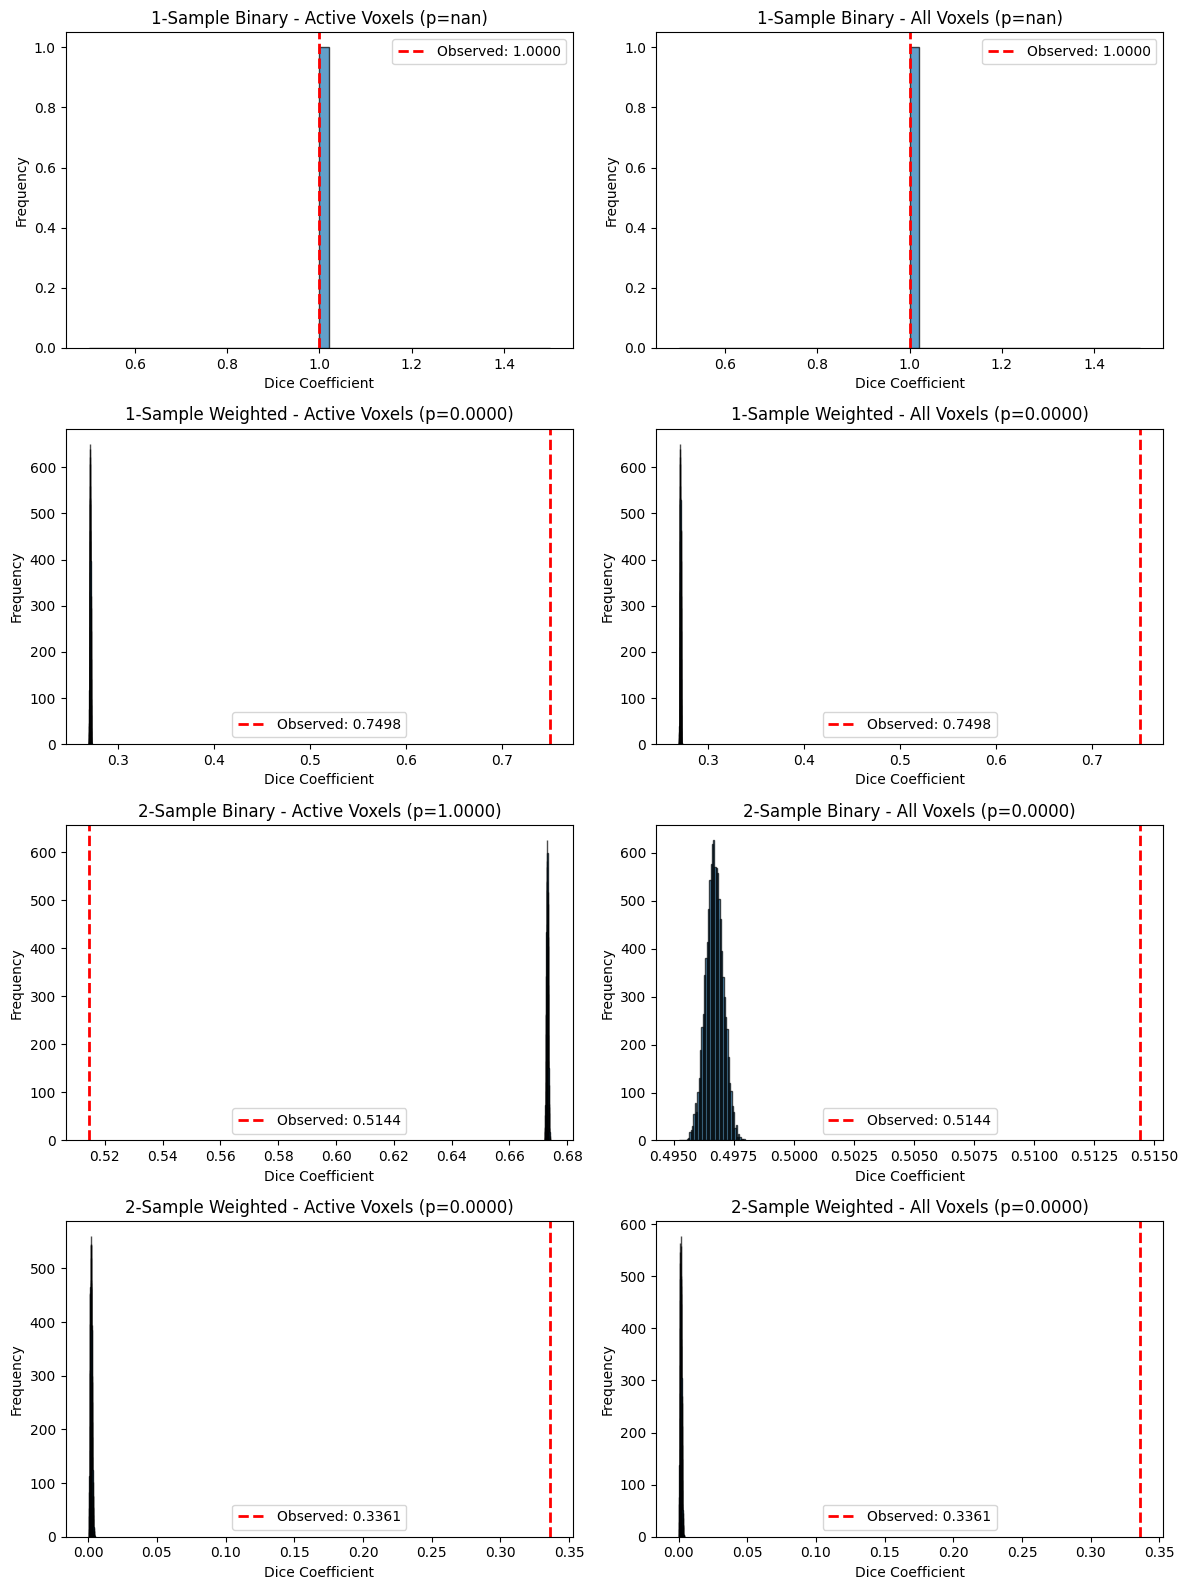


Null distribution statistics (Active Voxels):
1-Sample Binary: mean=1.0000, observed=1.0000
1-Sample Weighted: mean=0.2709, observed=0.7498
2-Sample Binary: mean=0.6731, observed=0.5144
2-Sample Weighted: mean=0.0021, observed=0.3361

Null distribution statistics (All Voxels):
1-Sample Binary: mean=1.0000, observed=1.0000
1-Sample Weighted: mean=0.2709, observed=0.7498
2-Sample Binary: mean=0.4967, observed=0.5144
2-Sample Weighted: mean=0.0016, observed=0.3361


In [21]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 2, figsize=(12, 16))

# 1-Sample Binary (Active Voxels)
axes[0, 0].hist(null_binary_1s_active, bins=50, alpha=0.7, edgecolor='black')
axes[0, 0].axvline(obs_binary_1s_active, color='red', linestyle='--', linewidth=2, label=f'Observed: {obs_binary_1s_active:.4f}')
axes[0, 0].set_xlabel('Dice Coefficient')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title(f'1-Sample Binary - Active Voxels (p={p_binary_1s_active:.4f})')
axes[0, 0].legend()

# 1-Sample Binary (All Voxels)
axes[0, 1].hist(null_binary_1s_all, bins=50, alpha=0.7, edgecolor='black')
axes[0, 1].axvline(obs_binary_1s_all, color='red', linestyle='--', linewidth=2, label=f'Observed: {obs_binary_1s_all:.4f}')
axes[0, 1].set_xlabel('Dice Coefficient')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title(f'1-Sample Binary - All Voxels (p={p_binary_1s_all:.4f})')
axes[0, 1].legend()

# 1-Sample Weighted (Active Voxels)
axes[1, 0].hist(null_weighted_1s_active, bins=50, alpha=0.7, edgecolor='black')
axes[1, 0].axvline(obs_weighted_1s_active, color='red', linestyle='--', linewidth=2, label=f'Observed: {obs_weighted_1s_active:.4f}')
axes[1, 0].set_xlabel('Dice Coefficient')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title(f'1-Sample Weighted - Active Voxels (p={p_weighted_1s_active:.4f})')
axes[1, 0].legend()

# 1-Sample Weighted (All Voxels)
axes[1, 1].hist(null_weighted_1s_all, bins=50, alpha=0.7, edgecolor='black')
axes[1, 1].axvline(obs_weighted_1s_all, color='red', linestyle='--', linewidth=2, label=f'Observed: {obs_weighted_1s_all:.4f}')
axes[1, 1].set_xlabel('Dice Coefficient')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title(f'1-Sample Weighted - All Voxels (p={p_weighted_1s_all:.4f})')
axes[1, 1].legend()

# 2-Sample Binary (Active Voxels)
axes[2, 0].hist(null_binary_2s_active, bins=50, alpha=0.7, edgecolor='black')
axes[2, 0].axvline(obs_binary_2s_active, color='red', linestyle='--', linewidth=2, label=f'Observed: {obs_binary_2s_active:.4f}')
axes[2, 0].set_xlabel('Dice Coefficient')
axes[2, 0].set_ylabel('Frequency')
axes[2, 0].set_title(f'2-Sample Binary - Active Voxels (p={p_binary_2s_active:.4f})')
axes[2, 0].legend()

# 2-Sample Binary (All Voxels)
axes[2, 1].hist(null_binary_2s_all, bins=50, alpha=0.7, edgecolor='black')
axes[2, 1].axvline(obs_binary_2s_all, color='red', linestyle='--', linewidth=2, label=f'Observed: {obs_binary_2s_all:.4f}')
axes[2, 1].set_xlabel('Dice Coefficient')
axes[2, 1].set_ylabel('Frequency')
axes[2, 1].set_title(f'2-Sample Binary - All Voxels (p={p_binary_2s_all:.4f})')
axes[2, 1].legend()

# 2-Sample Weighted (Active Voxels)
axes[3, 0].hist(null_weighted_2s_active, bins=50, alpha=0.7, edgecolor='black')
axes[3, 0].axvline(obs_weighted_2s_active, color='red', linestyle='--', linewidth=2, label=f'Observed: {obs_weighted_2s_active:.4f}')
axes[3, 0].set_xlabel('Dice Coefficient')
axes[3, 0].set_ylabel('Frequency')
axes[3, 0].set_title(f'2-Sample Weighted - Active Voxels (p={p_weighted_2s_active:.4f})')
axes[3, 0].legend()

# 2-Sample Weighted (All Voxels)
axes[3, 1].hist(null_weighted_2s_all, bins=50, alpha=0.7, edgecolor='black')
axes[3, 1].axvline(obs_weighted_2s_all, color='red', linestyle='--', linewidth=2, label=f'Observed: {obs_weighted_2s_all:.4f}')
axes[3, 1].set_xlabel('Dice Coefficient')
axes[3, 1].set_ylabel('Frequency')
axes[3, 1].set_title(f'2-Sample Weighted - All Voxels (p={p_weighted_2s_all:.4f})')
axes[3, 1].legend()

plt.tight_layout()
plt.savefig(op.join(data_dir, 'dice_permutation_distributions.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\nNull distribution statistics (Active Voxels):")
print(f"1-Sample Binary: mean={np.mean(null_binary_1s_active):.4f}, observed={obs_binary_1s_active:.4f}")
print(f"1-Sample Weighted: mean={np.mean(null_weighted_1s_active):.4f}, observed={obs_weighted_1s_active:.4f}")
print(f"2-Sample Binary: mean={np.mean(null_binary_2s_active):.4f}, observed={obs_binary_2s_active:.4f}")
print(f"2-Sample Weighted: mean={np.mean(null_weighted_2s_active):.4f}, observed={obs_weighted_2s_active:.4f}")

print("\nNull distribution statistics (All Voxels):")
print(f"1-Sample Binary: mean={np.mean(null_binary_1s_all):.4f}, observed={obs_binary_1s_all:.4f}")
print(f"1-Sample Weighted: mean={np.mean(null_weighted_1s_all):.4f}, observed={obs_weighted_1s_all:.4f}")
print(f"2-Sample Binary: mean={np.mean(null_binary_2s_all):.4f}, observed={obs_binary_2s_all:.4f}")
print(f"2-Sample Weighted: mean={np.mean(null_weighted_2s_all):.4f}, observed={obs_weighted_2s_all:.4f}")

In [22]:
# Create summary dataframe with proper p-value formatting
def format_pvalue(p):
    if np.isnan(p):
        return "N/A (identical)"
    elif p == 0.0:
        return "< 0.0001"
    else:
        return f"{p:.6f}"

summary_data = {
    "Analysis Type": [
        "Group Average (1-Sample)", 
        "Group Average (1-Sample)",
        "Group Comparison (2-Sample)",
        "Group Comparison (2-Sample)"
    ],
    "Voxel Set": [
        "Active Only",
        "All Brain",
        "Active Only",
        "All Brain"
    ],
    "Binary Dice": [
        f"{dice_1s:.4f}", 
        f"{dice_1s:.4f}",
        f"{dice_2s:.4f}",
        f"{dice_2s:.4f}"
    ],
    "Binary p-value": [
        format_pvalue(p_binary_1s_active), 
        format_pvalue(p_binary_1s_all),
        format_pvalue(p_binary_2s_active),
        format_pvalue(p_binary_2s_all)
    ],
    "Weighted Dice": [
        f"{weighted_dice_1s:.4f}", 
        f"{weighted_dice_1s:.4f}",
        f"{weighted_dice_2s:.4f}",
        f"{weighted_dice_2s:.4f}"
    ],
    "Weighted p-value": [
        format_pvalue(p_weighted_1s_active), 
        format_pvalue(p_weighted_1s_all),
        format_pvalue(p_weighted_2s_active),
        format_pvalue(p_weighted_2s_all)
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n=== Dice Similarity Summary ===")
print(summary_df.to_string(index=False))
print("\nInterpretation:")
print("- Binary Dice = 1.0 means the thresholded maps are identical in spatial extent")
print("- Weighted Dice < 1.0 means activation magnitudes differ even when locations overlap")
print("\nPermutation Test Approaches:")
print("- Active Only: Tests if activated regions overlap more than chance (excludes zeros)")
print("- All Brain: Tests if spatial patterns are similar across entire brain (includes zeros)")
print("\nFor group difference maps:")
print("- 'Active Only' tests: Do the two seeds identify differences in overlapping locations?")
print("- 'All Brain' tests: Are the full spatial patterns (where + where not) similar?")


=== Dice Similarity Summary ===
              Analysis Type   Voxel Set Binary Dice  Binary p-value Weighted Dice Weighted p-value
   Group Average (1-Sample) Active Only      1.0000 N/A (identical)        0.7498         < 0.0001
   Group Average (1-Sample)   All Brain      1.0000 N/A (identical)        0.7498         < 0.0001
Group Comparison (2-Sample) Active Only      0.5144        1.000000        0.3361         < 0.0001
Group Comparison (2-Sample)   All Brain      0.5144        < 0.0001        0.3361         < 0.0001

Interpretation:
- Binary Dice = 1.0 means the thresholded maps are identical in spatial extent
- Weighted Dice < 1.0 means activation magnitudes differ even when locations overlap

Permutation Test Approaches:
- Active Only: Tests if activated regions overlap more than chance (excludes zeros)
- All Brain: Tests if spatial patterns are similar across entire brain (includes zeros)

For group difference maps:
- 'Active Only' tests: Do the two seeds identify differences 

## Save Results

In [23]:
# Save summary to CSV
output_fn = op.join(data_dir, "dice_similarity_results.csv")
summary_df.to_csv(output_fn, index=False)
print(f"\nResults saved to: {output_fn}")


Results saved to: ./dset/dice_similarity_results.csv


In [24]:
# Check if observed Dice is far outside the null distribution
import numpy as np

# For 1-sample (Group Average)
def check_robustness(observed, null, label):
    mean_null = np.mean(null)
    std_null = np.std(null)
    z_score = (observed - mean_null) / std_null if std_null > 0 else np.nan
    print(f"{label}:")
    print(f"  Observed Dice: {observed:.4f}")
    print(f"  Null mean:     {mean_null:.4f}")
    print(f"  Null std:      {std_null:.4f}")
    print(f"  Z-score:       {z_score:.2f}")
    if z_score > 3:
        print("  Result is robust: observed value is far outside the null distribution (z > 3)")
    elif z_score > 2:
        print("  Result is likely robust (z > 2)")
    else:
        print("  Result is not far outside the null (z <= 2)")
    print()

print("=== Active Voxels Only ===")
check_robustness(obs_binary_1s_active, null_binary_1s_active, "1-Sample Binary Dice")
check_robustness(obs_weighted_1s_active, null_weighted_1s_active, "1-Sample Weighted Dice")
check_robustness(obs_binary_2s_active, null_binary_2s_active, "2-Sample Binary Dice")
check_robustness(obs_weighted_2s_active, null_weighted_2s_active, "2-Sample Weighted Dice")

print("\n=== All Brain Voxels ===")
check_robustness(obs_binary_1s_all, null_binary_1s_all, "1-Sample Binary Dice")
check_robustness(obs_weighted_1s_all, null_weighted_1s_all, "1-Sample Weighted Dice")
check_robustness(obs_binary_2s_all, null_binary_2s_all, "2-Sample Binary Dice")
check_robustness(obs_weighted_2s_all, null_weighted_2s_all, "2-Sample Weighted Dice")

=== Active Voxels Only ===
1-Sample Binary Dice:
  Observed Dice: 1.0000
  Null mean:     1.0000
  Null std:      0.0000
  Z-score:       nan
  Result is not far outside the null (z <= 2)

1-Sample Weighted Dice:
  Observed Dice: 0.7498
  Null mean:     0.2709
  Null std:      0.0004
  Z-score:       1250.26
  Result is robust: observed value is far outside the null distribution (z > 3)

2-Sample Binary Dice:
  Observed Dice: 0.5144
  Null mean:     0.6731
  Null std:      0.0003
  Z-score:       -572.99
  Result is not far outside the null (z <= 2)

2-Sample Weighted Dice:
  Observed Dice: 0.3361
  Null mean:     0.0021
  Null std:      0.0006
  Z-score:       519.70
  Result is robust: observed value is far outside the null distribution (z > 3)


=== All Brain Voxels ===
1-Sample Binary Dice:
  Observed Dice: 1.0000
  Null mean:     1.0000
  Null std:      0.0000
  Z-score:       nan
  Result is not far outside the null (z <= 2)

1-Sample Weighted Dice:
  Observed Dice: 0.7498
  Null